# Data cleaning and transformation notebook


This notebook cleans, transforms, and generates five datasets for analysis. The processed data is exported as CSV files and imported into Tableau for visualization and further insights.

## 📌 Datasets Created and Processed

### 1️⃣ Registration Dataset

**Source:** Registration dataset

**Purpose:** Contains basic user information for demographic analysis and user segmentation.

**Processing:** Checked for null values, duplicates, and invalid entries before exporting to Tableau.

**Final Use:** Used for age and gender analysis and as a base dataset for joining transactions.

### 2️⃣ Appointments Dataset

**Source:** Appoinments dataset

**Purpose:** Stores all user sessions until the analysis cutoff date (August 31, 2024).

**Processing:**
   - Identified and handled null and duplicated values.
   - Reclassified session_status to distinguish between completed, canceled, and no-show sessions.
   - Created a `is_first_session` column to differentiate free and paid sessions.
 

**Final Use:** Used for analyzing user session behaviors, cancellations, and free trial engagement.

### 2.1 Cancel Rescheduled Dataset 

**Source:**  Appointments Dataset

**Purpose:** Tracks users who canceled their free session and whether they rescheduled.

**Processing:**
   - Created a `is_valid_cancel` column to classify cancellations as valid or invalid based on the cancellation time.
   - Merged session data with payment data to check if users rescheduled before purchasing a paid session.
   - Created `has_reschedule` collumn to indicate whether a user rescheduled their free session.


**Final Use**  Helps measure user engagement with free trial

### 3️⃣ Purchase Dataset 
**Source:** Payments dataset

**Purpose:**  Stores all user payment transactions.

**Processing:** 
- Created `package` column that show the number of sessions purchased by each user
- Created `purchase_position` column that indicates a purchase's position in all purchases of a user. It helps identifies first-time and repeated purchases.
- Created `days_between_purchases` column to measures time intervals between purchases.


**Final Use:** Used to analyze user retention, package preference, and purchase patterns.

### 4️⃣ User Status Dataset

**Source:** Appointments and Payments dataset

**Purpose:** Classifies users into status categories based on their last purchase and credit balance as of the analysis cutoff date (August 31, 2024.)

**Processing:**
- Exploratory analysis on days_between_purchases to establish criterias for user status classification.
- Created `last_purchase_date` column to  track user's last purchase
- Created `has_credits` column to identify if the user has remaining session credits.
- Use the new colums to classify user's status
.

**Final Use:** Used to track retention, churn, and identify users for targeted engagement strategies.


# Data source

The original datasets, except the Payments dataset, were queried from SQL databases of the telemedice app. The Payments dataset is exported from a financial platform used to complete online transactions for the Canada userbase.

For confidentiality reasons, I have randomly sampled 30% of the Canada userbase to demonstrate the data cleaning and transformation process in this Notebook. When printing a dataset, I will mask confidential columns for security.

# 📚 Imports 

In [38]:
import pandas as pd
import random 
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import re


# 1️⃣Registration dataset

**Dataset Overview**

This dataset contains registration details of users from Canada who have registered an account.  Each row represents a unique user, identified by a user_id. The dataset includes personal details relevant for demographic analysis and data integration with other datasets.

**Final Dataset's Columns**

- user_id (string): A unique identifier assigned to each user.
- email (string): The user's email address, which will be used to join payments and appointment data.
- register_date (datetime): The timestamp when the user completed their registration.
- age (float): The user’s age, calculated from user's birthdate 
- gender (string): The user’s self-reported gender, which may be used for demographic insights.

**Dataset Purpose**

This dataset is primarily used for:

- Joining other datasets for all the Gender and Age analysis in Tableau dashboards.
- Joining with transaction and appointment datasets via the email field.

**Data Processing**

- Basic Data Inspection: Used `df.info()` to check column data types and missing values.
- Duplicate Checks: Checked for duplicate duplicate values in specified columns.
- Null Value Analysis: Calculated the percentage of missing values in key demographic fields (birthdate and gender).
- Create an `age` column from `birthdate` column

## Data cleaning

In [1]:

registered_users_df = pd.read_csv("registered_users.csv")

#Show the df 
registered_users_show_df = registered_users_df.drop(columns = ["email"])
registered_users_show_df

,user_id,register_date,birthdate,gender
0,dff8388a-186a-4b34-b114-d745eb718ea7,2024-07-28 18:41:44.152,1950-07-30,male
1,3990ffc1-a28d-4197-ac5e-eb4a923d6b69,2024-07-16 21:59:22.068,1981-02-24,female
2,4722842c-bb87-401b-921a-ab907752c4b0,2024-06-30 13:38:26.998,1977-08-05,male
3,b7d19997-f9fa-476c-9934-69577a4cba9b,2024-08-01 15:02:03.925,NaN,NaN
4,0b30779e-5d08-42ab-aa71-159656d053df,2024-05-28 00:14:14.186,1996-08-10,male
...,...,...,...,...
534,da812f5e-c8d3-4c07-bee0-69ef16be1b31,2024-02-01 14:47:49.377,28/08/1997,female
535,4fde0fc6-3add-4757-a6b8-49fb19a286cc,2024-05-28 20:12:03.966,1988-08-15,male
536,9ddb5e2f-1932-459b-b316-eff0d24dfb26,2024-03-13 13:19:02.583,28/09/1986,female
537,dad5e92e-da3e-4509-b476-e5ddfd2a7590,2024-06-23 18:07:45.448,1980-12-05,male


In [15]:
def print_df_info(df, columns = None):
    """
    Prints the basic information of the DataFrame, including column types, missing values, 
    and duplicate row counts for specified columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to inspect.
    columns (list, optional): List of columns that should not have duplicate values.

    """
    print("Information of registered_users_df: \n", df.info())
    
    #If none columns are specified, check all columns
    if not columns:
        print("\n\nDuplicated:\n", df.duplicated().sum())
    
    print(f"\nDuplicated in {columns} (including all the duplicated rows):\n {df.duplicated(subset = columns, keep = False).sum()}")
    
    
    
print_df_info(registered_users_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        539 non-null    object
 1   email          539 non-null    object
 2   register_date  539 non-null    object
 3   birthdate      514 non-null    object
 4   gender         514 non-null    object
dtypes: object(5)
memory usage: 21.2+ KB
Information of registered_users_df: 
 None


Duplicated:
 0

Duplicated in None (including all the duplicated rows):
 0


### Data Cleaning: Null values 

Null values up to 5% is reasonable

In [3]:
def count_null_percentage(df, null_column):
    """
    Computes and prints the percentage of missing values in a specified column.

    Parameters:
    df (pd.DataFrame): The DataFrame to inspect.
    column (str): List of columns which missing values should be analyzed.
    
    """
    null_values = df[null_column].isna().sum()
    print(f"Percentage of null values of {null_column}: {null_values/len(df) *100:.2f}%")
    
#Count the number of UNIQUE users with null values on birthdate and gender
unique_users_df = registered_users_df.drop_duplicates(subset = "user_id")
count_null_percentage(unique_users_df, 'birthdate')
count_null_percentage(unique_users_df, 'gender')

Percentage of null values of birthdate: 4.64%
Percentage of null values of gender: 4.64%


## Data processing: create an `age` column

In [4]:
registered_users_copy_df = registered_users_df.copy()

In [5]:

def extract_year(date_str):
    """
    Extracts the year of birthdate column
    """
    #Possible birthdates format 
    date_formats = ['%Y-%m-%d', '%d/%m/%Y', '%Y%m%d', '%m/%d/%Y', '%d-%m-%Y']
    for fmt in date_formats:
        try:
            # Try converting with current format
            return pd.to_datetime(date_str, format=fmt, errors='raise').year
        except (ValueError, TypeError):
            continue
        # Try converting with the generic format
        try:
            return pd.to_datetime(date_str, errors='coerce').year
        except Exception:
            return None

# Calculate age 
def calculate_age(birth_year, current_year=2024):
    if pd.isnull(birth_year):
        return None
    return current_year - birth_year


registered_users_copy_df['birth_year'] = registered_users_copy_df['birthdate'].apply(extract_year)
registered_users_copy_df['age'] = registered_users_copy_df['birth_year'].apply(calculate_age)

registered_users_copy_df[["user_id", "age","birthdate" ]]

,user_id,age,birthdate
0,dff8388a-186a-4b34-b114-d745eb718ea7,74.0,1950-07-30
1,3990ffc1-a28d-4197-ac5e-eb4a923d6b69,43.0,1981-02-24
2,4722842c-bb87-401b-921a-ab907752c4b0,47.0,1977-08-05
3,b7d19997-f9fa-476c-9934-69577a4cba9b,NaN,NaN
4,0b30779e-5d08-42ab-aa71-159656d053df,28.0,1996-08-10
...,...,...,...
534,da812f5e-c8d3-4c07-bee0-69ef16be1b31,27.0,28/08/1997
535,4fde0fc6-3add-4757-a6b8-49fb19a286cc,36.0,1988-08-15
536,9ddb5e2f-1932-459b-b316-eff0d24dfb26,38.0,28/09/1986
537,dad5e92e-da3e-4509-b476-e5ddfd2a7590,44.0,1980-12-05


In [6]:

#Randomly print 10 of these users and manually inspect if the age is correctly calculated 
def randomly_print_samples(target_df, target_columns  = None):
    users = target_df["user_id"].unique()
    
    for i in range(10): #We can keep repeating this to get different users
        random_user = random.choice(users)
        verification_sample = target_df[target_df["user_id"] == random_user]
        print(f"Random user {i}:\n {verification_sample[target_columns]}")
        print("\n##########\n")
        
non_null_birthdates = registered_users_copy_df[registered_users_copy_df["age"].notna()]
randomly_print_samples(non_null_birthdates, ["birthdate", "age"])

Random user 0:
       birthdate   age
365  1996-12-26  28.0

##########

Random user 1:
       birthdate   age
363  1988-03-10  36.0

##########

Random user 2:
       birthdate   age
373  1980-06-06  44.0

##########

Random user 3:
       birthdate   age
322  24/11/1988  36.0

##########

Random user 4:
       birthdate   age
302  1984-10-05  40.0

##########

Random user 5:
       birthdate   age
502  1991-12-07  33.0

##########

Random user 6:
       birthdate   age
178  1980-04-10  44.0

##########

Random user 7:
       birthdate   age
490  1990-06-03  34.0

##########

Random user 8:
       birthdate   age
526  18/08/1991  33.0

##########

Random user 9:
      birthdate   age
25  28/08/1972  52.0

##########



In [7]:
#Export dataset to tableau

final_registered_users_df = registered_users_copy_df[["user_id", "register_date","email", "gender", "age" ]]

final_registered_users_df.to_csv("final_registered_users.csv", index = False)

# 2️⃣Appointments 

**Dataset Overview**
This dataset contains session details for all registered users up to August 31, 2024. Each row represents an individual session, identified by a unique session_id. It tracks session statuses, cancellations, and user behaviors.

**Final Dataset's Columns**

- user_id (string): Unique identifier for the user.
- cancel_at (datetime, nullable): Timestamp of session cancellation, if applicable.
- cancel_description (string, nullable): Reason for cancellation, if provided.
- session_date (datetime): Scheduled date and time of the session.
- session_id (string): Unique identifier for each session.
- session_status (string): Status of the session (finalizadas for completed, or other status codes).
- csat (float, nullable): Customer satisfaction score (CSAT) after the session.
- is_first_session (binary): 1 if it is the user’s first session, 0 otherwise.

**Dataset Purpose**

- First Sessions Engagement: Identify ratios of completed, canceled, and no-show sessions
- Rescheduling pattern: Identify users who rescheduled the free sessions after canceling
- No-show pattern: Identify users who miss the free sessions and/or paid sessions without canceling the session

**Data Processing**
- Basic Data Inspection with df.info() 
- Handling Missing and Duplicate Values
- Removing Test Cases from the Developers Team
- Refining Session Status Labels: The original session status only distinguishes between 'completed' and 'canceled'. However, some cases were 'no-shows'—where users missed their session without actively canceling. This was relabeled for accuracy.
- Identifying First Sessions: Added an is_first_session column (1 if it's a user's first session, 0 otherwise). This helps differentiate free trial sessions from paid sessions, as every user’s first session is free.

In [22]:


appointments_df = pd.read_csv("appointments.csv")


In [23]:
appointments_df 

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat
0,9ddb5e2f-1932-459b-b316-eff0d24dfb26,NaN,NaN,2024-05-21 14:30:00,15428c5a-623d-4eed-a203-df207ae5f500,finalizadas,1.0
1,b8bd05e0-3e55-483a-9aa7-f86b6a20944b,NaN,NaN,2024-07-09 00:00:00,778151f4-4347-496b-89a2-4af321921b10,finalizadas,1.0
2,378b695e-cf4d-49d1-9ac6-f8218ce58472,NaN,NaN,2024-01-22 08:30:00,bce87b43-9fb7-40eb-9457-5028a8191c07,finalizadas,1.0
3,33507078-c73b-4e42-98db-2d8e9f4e77b9,NaN,NaN,2024-08-13 18:00:00,02050e34-e9c0-42aa-8e7a-ffe9903748b2,finalizadas,NaN
4,7546a1e6-df79-4d0f-aa1d-f925e85235c4,NaN,NaN,2024-03-21 17:00:00,72a01566-853b-4d4d-b547-dff566bb35f5,finalizadas,1.0
...,...,...,...,...,...,...,...
860,c23b5c39-41dc-4b94-b694-560ecbf2f9a6,NaN,NaN,2024-01-12 00:00:00,aee87825-5337-44ee-8112-065b4219d4c2,finalizadas,1.0
861,c23b5c39-41dc-4b94-b694-560ecbf2f9a6,NaN,NaN,2023-07-28 00:00:00,3ea8fff2-06c5-4e49-8cea-2b1446c3afb4,finalizadas,2.0
862,c23b5c39-41dc-4b94-b694-560ecbf2f9a6,NaN,NaN,2024-03-05 15:30:00,def6a960-3cf5-48f5-bef4-1a93c95ad881,finalizadas,1.0
863,c39edd53-155b-4925-a4a8-cd9cecd0a87d,NaN,NaN,2024-01-30 11:00:00,c9b28b9c-af12-4d10-af3f-ccf93ad89d3c,finalizadas,1.0


In [24]:
print_df_info(appointments_df, columns = ["session_id"])
print("\n##############################################\n")
print_df_info(appointments_df, columns = ["user_id", "session_date"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             865 non-null    object 
 1   cancel_at           247 non-null    object 
 2   cancel_description  249 non-null    object 
 3   session_date        865 non-null    object 
 4   session_id          865 non-null    object 
 5   session_status      838 non-null    object 
 6   csat                399 non-null    float64
dtypes: float64(1), object(6)
memory usage: 47.4+ KB
Information of registered_users_df: 
 None

Duplicated in ['session_id'] (including all the duplicated rows):
 0

##############################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             865 non-null 

## Data cleaning

### Data cleaning: Duplicates
We noticed that some users have multiple sessions at the same time, but with different session_id values. This is unusual, as users typically don't book multiple sessions simultaneously.

To investigate, we filtered and examined such cases:

In [25]:
duplicated_session_dates_df = appointments_df[appointments_df.duplicated(subset = ['user_id', 'session_date'] , keep = False)].sort_values(by = ['user_id', 'session_date'] )
duplicated_session_dates_df                                                                                                  

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat
540,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,NaN,NaN,2024-06-10 10:00:00,c280be78-5f74-4247-b19c-25d3c0580cf2,finalizadas,1.0
580,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,31/5/2024 20:24:22,Prefiro marcar com profissional que gostei \n,2024-06-10 10:00:00,18753a04-e2c8-4dcb-8624-c7f41867fb36,canceladas,NaN


It appears that some users canceled a session to switch to a different doctor but kept the same session time. We confirmed this by merging the dataset with the doctor_id in each session



In [26]:
doctors_df  = pd.read_csv("doctors_sessions.csv")


In [27]:
#Filter the sessions with duplicated session date 

appointments_doctors_df = appointments_df[appointments_df["session_id"].isin(duplicated_session_dates_df["session_id"])]

appointments_doctors_df = appointments_doctors_df.merge(doctors_df, on = "session_id", how = "left")

appointments_doctors_df

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat,doctor_id
0,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,NaN,NaN,2024-06-10 10:00:00,c280be78-5f74-4247-b19c-25d3c0580cf2,finalizadas,1.0,02d3c8ad-09eb-4b3b-b3da-28081a723bad
1,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,31/5/2024 20:24:22,Prefiro marcar com profissional que gostei \n,2024-06-10 10:00:00,18753a04-e2c8-4dcb-8624-c7f41867fb36,canceladas,NaN,43ed84bc-d913-4a2e-93df-084d55a766ec


Note that the doctor_ids are different. Hence the issue with session_date is likely due to the change of therapists for the same appointment time.

We will keep both cases as it is relevant to know that some users had to go througu the effort of canceling and re-booking session for the same time justto change doctors. 


### Data Cleaning:  Test cases

Remove any data that is produced during the testing sessions

In [28]:


def remove_test_cases(df):
    """
    Removes any data that was produced during the testing sessions to avoid bias.
    """
    
    # Normalize cancel_description 
    df['cancel_description'] = df['cancel_description'].apply(
        lambda x: unidecode(str(x).lower().strip()) if pd.notna(x) else x
    )
    
    # Identify rows that have the keyword 'test'
    test_rows = df[df['cancel_description'].str.contains('test', na=False)]

    print("\nRows removed due to 'test' in cancel_description:\n", test_rows['cancel_description'])

    # Remove the  rows
    df = df[~df['cancel_description'].str.contains('test', na=False)]

    
    return df

appointments_df = remove_test_cases(appointments_df)




Rows removed due to 'test' in cancel_description:
 13      teste teste teste
470       testetwztetwste
615    testes em producao
Name: cancel_description, dtype: object


### Data Cleaning: Null values

**Columns that should not have nulll values**

- user_id: Unique identifier for each user.

- session_date: The date and time of the scheduled session.

- session_id: Unique identifier for each session.

- session_status: The session outcome ("finalizadas" (finished), "canceladas"(canceled)).
As confirmed in the print_data_info() function, these columns contain zero null values


**Columns that can have null values**

- cancel_at: This column should only have values when session_status = 'canceladas'. Sessions that were completed or not canceled can have null values in this field.

- cancel_description: Not all canceled sessions include a reason, so this field can be null. 
However, if a row has a value in cancel_description, it must also have a non-null cancel_at value.

- csat: Represents customer satisfaction scores, but not all users leave a rating.

In [29]:
#Check if  all rows with a value in cancel_at column has session_status = 'canceladas'
cancel_at_rows = appointments_df.loc[appointments_df["cancel_at"].notna()]
cancel_at_status = cancel_at_rows["session_status"].unique()
print("All rows with a value in cancel_at have session_status='canceladas: ", cancel_at_status)

# Check if all rows with a value in cancel_description column has a non-null value at cancel_at column
cancel_descrip_rows = appointments_df.loc[appointments_df["cancel_description"].notna()]
cancel_description_cancel_at = cancel_descrip_rows["cancel_at"].notna().all()
print(f"All rows with a value in cancel_description have a non-null cancel_at:", cancel_description_cancel_at)


All rows with a value in cancel_at have session_status='canceladas:  ['canceladas' nan]
All rows with a value in cancel_description have a non-null cancel_at: False


**We identified cases where cancel_at has a value, but session_status is null.** These cases are likely due to a technical issue that failed to record the cancellation timestamp properly, rather than an actual data error.

We will address these null values when we review the session_status values later in the process.

In [30]:
#Investigate the null values at cancel_at when there is a cancel_description
cancel_descrip_rows[cancel_descrip_rows["cancel_at"].isna()]


,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat
181,c39edd53-155b-4925-a4a8-cd9cecd0a87d,NaN,cancelado pelo suporte,2024-01-30 11:30:00,55b5585d-5370-454c-b6e0-0759c6e81d0c,canceladas,NaN
219,d38d820b-6a7b-49a4-b220-101441d2ba2b,NaN,cancelado pelo suporte,2023-07-16 00:00:00,99989c2f-e60e-4084-930c-bf047bd1153d,canceladas,NaN
311,0d4a4c6e-a7aa-4b56-be90-490e214aefdb,NaN,cancelado pelo suporte,2023-07-28 00:00:00,29252a22-9d9d-42d5-8c3f-e637832a4142,canceladas,NaN
571,1e171732-9d34-4c78-a087-a75795a6c484,NaN,cancelado pelo suporte,2024-01-02 18:00:00,4071dd38-4754-417a-a3e4-9434b37cc872,canceladas,NaN
614,2f20ca8c-f32c-4a9f-be71-48bf7f9948c7,NaN,cancelado pelo suporte,2023-07-15 00:00:00,2504ea2c-1bf0-400a-bf4a-fa06e5a68972,canceladas,NaN
778,3bac4ff9-1fc7-4411-b46b-a450a6ad48cf,NaN,cancelado pelo suporte,2024-06-03 20:30:00,4a2aac45-e5a5-4237-a489-12e05265c12b,canceladas,NaN


All these sessions here were explicitly canceled by Customer Support ("cancelado pelo suporte"). It's more likely to have a technical error where the timestamp wasn't record than have the human error by Customer Support team. 

We will treat these cases as valid cancellations, even though cancel_at is null.

## Data processing

### Data processing: Correcting session_status

The current data pipeline assigns session_status as either:

"finalizadas" (finished)
"canceladas" (canceled)
However, there is a third category: no-show, which occurs when users do not join the session without canceling or notifying the therapist.

After communicating with The Health Team, I confirmed that therapists record no-shows using a specific phrase in the cancel_description column:
*"O paciente não entrou na videochamada" (The patient did not join the video call).*

Thus, we will use a combination of cancel_at, cancel_description, and session_status to ensure correct classification.

In [31]:


def correct_session_status(row):
    """
    Corrects the session_status of each session based on cancel_at and cancel_description.
    """
    cancel_description = row["cancel_description"]
    
    # Define conditions
    is_no_show = pd.notna(cancel_description) and cancel_description == "o paciente nao entrou na videochamada"

    is_canceled = (
        pd.notna(cancel_description) and cancel_description != "o paciente nao entrou na videochamada"
    ) or (pd.notna(row["cancel_at"])) or (pd.isna(row["cancel_at"]) and pd.notna(cancel_description) and cancel_description != "o paciente nao entrou na videochamada" )

    is_finished = pd.isna(row["cancel_at"]) and pd.isna(row["cancel_description"])

    # Assign session status
    if is_no_show:
        return "no-show"
    elif is_canceled:
        return "canceled"
    elif is_finished:
        return "finished"
    else:
        return "other"

def apply_review_session_status(df):
    """
    Applies `correct_session_status` to the entire DataFrame.

    """
    df["session_status"] = df.apply(correct_session_status, axis=1) 
    
    print(df["session_status"].unique())  
    
    return df


In [32]:
appointments_copy_df  = appointments_df.copy()


In [33]:
appointments_copy_df = apply_review_session_status(appointments_copy_df)

['finished' 'canceled' 'no-show']


To ensure the function worked correctly across all records, we validated key characteristics of each session type:

In [34]:

print("Verifying if the correction process was successful: \n\n")

finished_df = appointments_copy_df[appointments_copy_df["session_status"] == "finished"]
print("Finished sessions")
print("Cancel at (should be 0): " , finished_df["cancel_at"].notna().sum())
print("Cancel description (should be 0): " , finished_df["cancel_description"].notna().sum())


canceled_df = appointments_copy_df[appointments_copy_df["session_status"] == "canceled"]
no_show_msg = canceled_df[canceled_df["cancel_description"] == "o paciente nao entrou na videochamada"]
print("\nCanceled sessions")
print("Null Cancel at (should be 0): " , canceled_df["cancel_at"].isna().sum())
print("Cancel description with No show message ( should be 0 ): " , len(no_show_msg))

no_show_df = appointments_copy_df[appointments_copy_df["session_status"] == "no-show"]
not_no_show_msg = no_show_df[no_show_df["cancel_description"] != "o paciente nao entrou na videochamada"]
print("\n No Show sessions")
print("Null Cancel at ( should be 0): " , no_show_df["cancel_at"].isna().sum())
print("All cancel description ( should be 0): " , len(not_no_show_msg))



Verifying if the correction process was successful: 


Finished sessions
Cancel at (should be 0):  0
Cancel description (should be 0):  0

Canceled sessions
Null Cancel at (should be 0):  6
Cancel description with No show message ( should be 0 ):  0

 No Show sessions
Null Cancel at ( should be 0):  0
All cancel description ( should be 0):  0


It's weird to have null values for cancel_at in the sessions classified as 'canceled'. Let's check these rows:

In [277]:
canceled_df[canceled_df["cancel_at"].isna()]

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat
181,c39edd53-155b-4925-a4a8-cd9cecd0a87d,NaN,cancelado pelo suporte,2024-01-30 11:30:00,55b5585d-5370-454c-b6e0-0759c6e81d0c,canceled,NaN
219,d38d820b-6a7b-49a4-b220-101441d2ba2b,NaN,cancelado pelo suporte,2023-07-16 00:00:00,99989c2f-e60e-4084-930c-bf047bd1153d,canceled,NaN
311,0d4a4c6e-a7aa-4b56-be90-490e214aefdb,NaN,cancelado pelo suporte,2023-07-28 00:00:00,29252a22-9d9d-42d5-8c3f-e637832a4142,canceled,NaN
571,1e171732-9d34-4c78-a087-a75795a6c484,NaN,cancelado pelo suporte,2024-01-02 18:00:00,4071dd38-4754-417a-a3e4-9434b37cc872,canceled,NaN
614,2f20ca8c-f32c-4a9f-be71-48bf7f9948c7,NaN,cancelado pelo suporte,2023-07-15 00:00:00,2504ea2c-1bf0-400a-bf4a-fa06e5a68972,canceled,NaN
778,3bac4ff9-1fc7-4411-b46b-a450a6ad48cf,NaN,cancelado pelo suporte,2024-06-03 20:30:00,4a2aac45-e5a5-4237-a489-12e05265c12b,canceled,NaN


As mentioned above, sessions with the phrase "canceled by customer supports" in the cancel_description column can be safely considered as canceled sessions.

### Data processing: Create `is_first_session` column

**What it's column about**

This column will serve to differentiate the first , free sessions from the paid sessions

**How it's created**
- Sort dataset by user id and session date
- Assign is_first_session = 1 to the first session of each user and is_first_session = 0 to the subsequent sessions

In [46]:
appointments_copy_df['session_date'] = pd.to_datetime(appointments_copy_df['session_date'], errors='coerce')

# Sort by user_id and session_date by ascending order 
appointments_copy_df = appointments_copy_df.sort_values(by=['user_id', 'session_date'])

# Assign 1 to the first session per user, else 0
appointments_copy_df['is_first_session'] = appointments_copy_df.duplicated(subset=['user_id'], keep='first').astype(int).replace({0: 1, 1: 0})


To ensure is_first_session was correctly assigned, we will:

- Filter users with multiple sessions.
- Sort by user_id and session_date in ascending order.
- Randomly sample different 10 rows to verify correctness without manually inspecting the entire dataset.


In [47]:


#Filter users with more than one session
duplicated_users = appointments_copy_df[appointments_copy_df.duplicated("user_id")]["user_id"].unique()
duplicated_users_df = appointments_copy_df[appointments_copy_df['user_id'].isin(duplicated_users)].sort_values(by=['user_id', 'session_date'])

#Randomly print 10 of these users and manually inspect if the session has 1 in the is_first_sessio field is indeed the session with the earliest date
def randomly_print_samples(target_df, target_columns  = None):
    users = target_df["user_id"].unique()
    
    for i in range(10): #We can keep repeating this to get different users
        random_user = random.choice(users)
        verification_sample = target_df[target_df["user_id"] == random_user]
        print(f"Random user {i}:\n {verification_sample[target_columns]}")
        print("\n##########\n")
        
randomly_print_samples(duplicated_users_df, ["session_date", "is_first_session"])

Random user 0:
            session_date  is_first_session
839 2024-03-08 14:00:00                 1
804 2024-04-07 16:30:00                 0
708 2024-06-07 14:00:00                 0
527 2024-06-29 14:00:00                 0
375 2024-07-11 00:00:00                 0
97  2024-07-13 14:00:00                 0
189 2024-07-18 16:00:00                 0
423 2024-07-18 16:30:00                 0
838 2024-08-10 00:00:00                 0
424 2024-08-17 14:00:00                 0

##########

Random user 1:
            session_date  is_first_session
606 2024-02-05 14:30:00                 1
407 2024-02-13 13:00:00                 0
143 2024-02-28 15:15:00                 0
214 2024-03-04 14:30:00                 0
383 2024-03-06 15:15:00                 0
118 2024-03-20 15:15:00                 0
832 2024-04-23 13:45:00                 0
6   2024-06-18 13:00:00                 0
822 2024-06-18 14:30:00                 0

##########

Random user 2:
            session_date  is_first_session
53

In [48]:
appointments_copy_df

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat,is_first_session
236,00328cff-7ce7-46ae-8319-732ac6429042,NaN,NaN,2023-12-09 00:00:00,e2423c70-11ae-4807-8b6f-9eacb64ba9d7,finished,1.0,1
758,00d1a842-9c2e-464c-b8e1-44e44c57b037,NaN,NaN,2024-04-03 11:15:00,b6230b0b-e818-4370-9025-a06cedb3fbdf,finished,NaN,1
728,02af1545-1f39-46b2-9687-337dd320bd27,NaN,NaN,2024-02-05 17:30:00,ba2fe9a8-c771-4fd4-859a-649387c9aed4,finished,2.0,1
829,02af1545-1f39-46b2-9687-337dd320bd27,NaN,NaN,2024-02-07 18:15:00,6be5489a-491c-4f1c-9a57-8828914d982e,finished,NaN,0
730,02af1545-1f39-46b2-9687-337dd320bd27,NaN,NaN,2024-02-09 00:00:00,eb4561e8-34ff-4302-8391-9211685cbf45,finished,1.0,0
...,...,...,...,...,...,...,...,...
261,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,NaN,NaN,2024-08-06 14:00:00,16978b91-f75d-418a-b134-a6fa7d8928bb,finished,2.0,0
299,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,NaN,NaN,2024-08-10 00:00:00,f638d3d3-bf80-4a6a-880c-4937d66380d5,finished,2.0,0
330,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,NaN,NaN,2024-08-16 15:00:00,a294a1db-2b3a-4459-bd8d-34510aba7f71,finished,NaN,0
131,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,7/8/2024 15:58:44,mudanca de horario,2024-08-30 15:00:00,ebd06333-a573-44d9-b264-10d132859308,canceled,NaN,0


In [49]:

appointments_copy_df.to_csv("final_appointments.csv", index = False)

# 2️⃣.1️⃣Cancel Rescheduled 

**Dataset Overview**
This dataset is derived from appointments_df and contains information about first sessions that were canceled and their corresponding rescheduled sessions

**Final Dataset's columns**
- user_id (string): Unique identifier for the user.
- cancel_at (datetime): Timestamp when the session was canceled.
- session_date (datetime): Scheduled date and time of the session.
- session_id (string): Unique identifier for the session.
- session_status (string): Final status of the session (canceled, finished).
- csat (float): Customer satisfaction score.
- is_first_session (binary): 1 if it is the user’s first session, 0 otherwise.
- is_valid_cancel (binary): 1 if the cancellation was made more than two hours before the session, allowing rescheduling.0 otherwise.
- has_reschedule (binary): 1 if the user booked another session after canceling, 0 otherwise.

**Dataset Purpose**

This dataset is used to analyze which users who cancel their first session are still interested in the service by rescheduling the free session

**Data Processing**
- **Identify Valid and Invalid Cancellations:**
   
   - Users who cancel more than two hours before (session_date - cancel_at > 2 hours) get a valid cancellation (is_valid_cancel = 1).
   - Users who cancel within two hours or less (session_date - cancel_at ≤ 2 hours) get an
        invalid cancellation (is_valid_cancel = 0).
  

- **Identify Rescheduled Sessions:**
    - Among users with a valid cancellation, check if they schedule another session before purchasing their first paid session. If the next session is before their first payment, it indicates they are still using the free session. Otherwise, they rescheduled a paid session.


- **Join Cancel Reschedule dataset with Payments dataset:**
    - This merge serves to identify whether the rescheduled sessions are from the same free sessions. Since the payments dataset comes from a NoSQL database and uses a different user identifier, email is used as the unique key to match users between the appointments and payments datasets.


### Data cleaning : payments df 

To generate the cancel_reschedule_df we need the `payment_date` field from the payments dataset. Therefore, we will clean it and merge it with the appointments dataset. 

In [37]:
#Import payments dataset 
payments_df = pd.read_csv("current_ca_payments.csv")

#Import dataset with user_id and email. I isolated it from main df for privacy reasons
user_emails = pd.read_csv("user_emails.csv")

In [39]:

def mask_email(email):
    """
    Replaces the email's characters with '*', except the first and last characters
    """
    match = re.match(r"([^@])([^@]*)(@.+)", email)
    if match:
        return match.group(1) + "*" * len(match.group(2)) + match.group(3)
    return email 



#Creating a copy to show the first rows as example of the dataset, while protecting sensible information
payments_show_df = payments_df.copy()
#Masking some fields for privacy
payments_show_df["Customer Email"] = payments_show_df["Customer Email"].apply(mask_email)
payments_show_df = payments_show_df.drop(columns = ["Statement Descriptor", "Card ID","Customer ID","id"])
payments_show_df[:5]

    

,Created date (UTC),Amount,Amount Refunded,Currency,Captured,Converted Amount,Converted Amount Refunded,Converted Currency,Decline Reason,Description,Fee,Refunded date (UTC),Status,Seller Message,Taxes On Fee,Customer Description,Customer Email,Invoice ID,Transfer
0,2024-08-19 16:47:35,76.74,0.0,cad,True,76.74,0.0,cad,NaN,Payment for Invoice,2.53,NaN,Paid,Payment complete.,0.0,NaN,r**********@icloud.com,in_1PpYjxKW0fKSu7kHfq2YVz7a,NaN
1,2024-08-19 14:47:01,140.68,0.0,cad,True,140.68,0.0,cad,NaN,Payment for Invoice,4.38,NaN,Paid,Payment complete.,0.0,NaN,s*********@privaterelay.appleid.com,in_1PpWrAKW0fKSu7kHCTiGL9YP,NaN
2,2024-08-19 01:09:44,239.84,0.0,cad,True,239.84,0.0,cad,NaN,Payment for Invoice,7.26,NaN,Paid,Payment complete.,0.0,NaN,l**********@hotmail.com,in_1PpK6BKW0fKSu7kHQEQ5HKb4,NaN
3,2024-08-18 11:26:26,239.84,0.0,cad,True,239.84,0.0,cad,NaN,Payment for Invoice,7.26,NaN,Paid,Payment complete.,0.0,NaN,h****@marcosrezende.com,in_1Pp7FQKW0fKSu7kHCKOaDhmb,NaN
4,2024-08-18 03:02:27,76.74,0.0,cad,True,76.74,0.0,cad,NaN,Payment for Invoice,2.53,NaN,Paid,Payment complete.,0.0,NaN,m*****@gmail.com,in_1PozNsKW0fKSu7kHqSxmaT09,NaN


### Data Cleaning: Null and duplicated values 

Only `transfer` column has null values. This is fine because we won't use it in our analysis

In [40]:
#Check if the dataset has null values or duplicates

print_df_info(payments_df, ["Invoice ID"])
print_df_info(payments_df, ["id"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         105 non-null    object 
 1   Created date (UTC)         105 non-null    object 
 2   Amount                     105 non-null    float64
 3   Amount Refunded            105 non-null    float64
 4   Currency                   105 non-null    object 
 5   Captured                   105 non-null    bool   
 6   Converted Amount           105 non-null    float64
 7   Converted Amount Refunded  105 non-null    float64
 8   Converted Currency         105 non-null    object 
 9   Decline Reason             0 non-null      float64
 10  Description                105 non-null    object 
 11  Fee                        105 non-null    float64
 12  Refunded date (UTC)        0 non-null      float64
 13  Statement Descriptor       105 non-null    object 

In [41]:
#Check if all the payments were successful ( status == paid)

payments_df["Status"].unique()

array(['Paid'], dtype=object)

### Data Cleaning: Filtering & Standardizing Payment Data

We only need the following columns from the payments dataset:

- id: Unique identifier for each payment.
- Customer Email: Used as the unique key to match users across SQL and NoSQL datasets.
- Converted Amount: Amount converted into Canadian currency.
- Created date (UTC): Represents the payment date.

In [42]:
payments_df = payments_df[['id', 'Created date (UTC)',  'Converted Amount', 'Customer Email']]

#Change the columns names to match other datasets
payments_df = payments_df.rename(columns = {"id": "payment_id", "Created date (UTC)": "payment_date_utc", "Converted Amount" : "payment_value_ca",
                             "Customer Email": "email"})

print("Current columns: ", payments_df.columns)

Current columns:  Index(['payment_id', 'payment_date_utc', 'payment_value_ca', 'email'], dtype='object')


## Data Processing

## Data processing: Create `is_valid_cancel` column

**What it's column about**
Users can reschedule sessions when the cancellation is valid

**How it's created**
- Calculate time difference between session date and cancel date 
- If the time difference is more than 2 hours , the cancellation is valid. If the time difference is less or equal to 2 hours, the cancellation is invalid. 

In [50]:
#Filter the first sessions 
first_sessions_df = appointments_copy_df[appointments_copy_df["is_first_session"] == 1]

#Filter the canceled first sessions
canceled_sessions_df = first_sessions_df[first_sessions_df['session_status'] == 'canceled']
print('Number of canceled first sessions: ', canceled_sessions_df["session_id"].nunique())


canceled_sessions_df['session_date'] = pd.to_datetime(canceled_sessions_df['session_date'], errors='coerce')
canceled_sessions_df['cancel_at'] = pd.to_datetime(canceled_sessions_df['cancel_at'], errors='coerce')

# Create 'is_valid_cancel' field based on the cancel time
def determine_valid_cancel(row):
    if pd.isna(row['cancel_at']):
        return pd.NA
   
    if (row['session_date'] - row['cancel_at']).total_seconds() > 7200:  # 2 hours 
        return 1
    else: 
        return 0
    
#Create is_valid_cancel column that indicates whether or not it was a valid cancellation
canceled_sessions_df['is_valid_cancel'] = canceled_sessions_df.apply(determine_valid_cancel, axis=1)

canceled_sessions_df[:5]

Number of canceled first sessions:  62


C:\Users\innyw\AppData\Local\Temp\ipykernel_22344\1602943562.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canceled_sessions_df['session_date'] = pd.to_datetime(canceled_sessions_df['session_date'], errors='coerce')
C:\Users\innyw\AppData\Local\Temp\ipykernel_22344\1602943562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canceled_sessions_df['cancel_at'] = pd.to_datetime(canceled_sessions_df['cancel_at'], errors='coerce')
C:\Users\innyw\AppData\Local\Temp\ipykernel_22344\1602943562.py:23: Setti

,user_id,cancel_at,cancel_description,session_date,session_id,session_status,csat,is_first_session,is_valid_cancel
659,05c5a3f0-7715-4c1d-b560-72c2a4148f99,2024-07-23 07:30:02,reserva cancelada,2024-07-25 11:00:00,295c18ca-41c0-42e8-b35c-af3bc11f3871,canceled,NaN,1,1
294,0ba2e3e6-c93e-47f7-814b-bd638e1bfffc,2024-03-06 22:46:35,"bom dia. aguardei pelo atendimento, mas voce n...",2024-04-06 19:30:00,310fc503-19a6-4a19-ba3d-e619d3ece789,canceled,NaN,1,1
298,1d799082-48a6-4699-a306-b351d6784b3c,2024-04-07 22:08:29,reserva cancelada,2024-07-29 13:00:00,c1e52249-98c7-4e0d-bdf7-519c47761fff,canceled,NaN,1,1
508,1e171732-9d34-4c78-a087-a75795a6c484,2023-12-13 16:03:34,agendamento com a pessoa errada,2023-07-12 16:03:34,9666ed47-96bc-4a08-b5db-781797b22d5c,canceled,NaN,1,0
273,1e640281-b77d-4224-9091-07a8eb9050e0,2024-01-02 11:20:28,trocar data e horario por 60 min,2024-01-02 20:00:00,40e89a31-c16b-42a6-8b49-f32b25074297,canceled,NaN,1,1


In [53]:
#Let's examine the rows to see if the operation was successful

#Randomly select 10 users and manually check the calculation
target_df = canceled_sessions_df.sort_values(by= ["user_id", "session_date"])
randomly_print_samples(target_df, ["user_id","cancel_at", "session_date", "is_valid_cancel"])


Random user 0:
                                   user_id           cancel_at  \
154  3b33d703-d17a-411e-a0de-7c590a651395 2024-05-29 12:37:43   

           session_date is_valid_cancel  
154 2024-04-06 14:00:00               0  

##########

Random user 1:
                                   user_id           cancel_at  \
715  69d7b4e9-e6a7-46b9-87c8-4a0b2c514f45 2024-04-18 23:40:13   

           session_date is_valid_cancel  
715 2024-04-18 23:30:00               0  

##########

Random user 2:
                                   user_id           cancel_at  \
235  dbbe5a0a-36cd-4f5b-8366-98c3c1c44a0e 2024-09-04 17:40:35   

           session_date is_valid_cancel  
235 2024-04-16 14:00:00               0  

##########

Random user 3:
                                   user_id           cancel_at session_date  \
280  31dd89c0-2b5f-48c0-b8f3-b36c343e0577 2024-08-04 14:49:02   2024-04-09   

    is_valid_cancel  
280               0  

##########

Random user 4:
                       

In [54]:
#Null values for is_valid_cancel
print("Null value for is_valid_cancel: ", canceled_sessions_df[canceled_sessions_df["is_valid_cancel"].isna()], "\n")


Null value for is_valid_cancel:                                    user_id cancel_at      cancel_description  \
778  3bac4ff9-1fc7-4411-b46b-a450a6ad48cf       NaT  cancelado pelo suporte   
219  d38d820b-6a7b-49a4-b220-101441d2ba2b       NaT  cancelado pelo suporte   

           session_date                            session_id session_status  \
778 2024-06-03 20:30:00  4a2aac45-e5a5-4237-a489-12e05265c12b       canceled   
219 2023-07-16 00:00:00  99989c2f-e60e-4084-930c-bf047bd1153d       canceled   

     csat  is_first_session is_valid_cancel  
778   NaN                 1            <NA>  
219   NaN                 1            <NA>   




Since there are cases where **cancel_at is null**, we cannot determine if these cancellations are valid yet.

To resolve this, we will later use the payments dataset to check if these users booked another session before making their first purchase.


### Data Processing: Create `has_reschedule` column 

**What it's column about**
This column will indicate if the session is a rescheduled free session or not.

**How it's created**
- Extract all second sessions of users with valid cancellations or cancel_at as null.
- Merge payment data to check if the rescheduled session is from the free session


In [56]:
#Get the users from canceled_df, and filter from appointments_df their earliest session that IT'S NOT a first session
#(`is_first_session` != 1)

# Extract users who have valid cancellations or null cancel at 
potential_reschedule_users = canceled_sessions_df[(canceled_sessions_df["is_valid_cancel"] == 1) | (canceled_sessions_df["is_valid_cancel"].isna())] 
potential_reschedule_users = potential_reschedule_users["user_id"].unique()

# Find their earliest session that is NOT their first session
second_sessions_df = (
    appointments_copy_df[
        (appointments_copy_df["user_id"].isin(potential_reschedule_users)) & (appointments_copy_df["is_first_session"] != 1)
    ]
    .sort_values(by=["user_id", "session_date"])  # Ensure correct order 
    .groupby("user_id", as_index=False)  # Select first occurrence per user
    .first()
)


# Validate operation by checking randomly selected users
for i in range(10):
    
    user = random.choice(potential_reschedule_users)
    print(f"\n\nUser {user}: ")
    
    #Check if the user's second session date is earlier to all the remaining session dates
    print("Date of the second session: ", second_sessions_df[second_sessions_df["user_id"] == user]["session_date"] )
    second_session_id = second_sessions_df[second_sessions_df["user_id"] == user]["session_id"]
    
    # Get remaining non-first sessions for the user
    not_first_sessions_df = appointments_copy_df[appointments_copy_df["is_first_session"] == 0]
    remaining_sessions_df = not_first_sessions_df[~not_first_sessions_df["session_id"].isin(second_session_id)]

    print("Dates of the remaining sessions: ", remaining_sessions_df[remaining_sessions_df["user_id"] == user]["session_date"])
    
    



User 8580da3b-0c1b-4adf-b20c-7077d71a616e: 
Date of the second session:  4   2024-02-29 15:00:00
Name: session_date, dtype: datetime64[ns]
Dates of the remaining sessions:  Series([], Name: session_date, dtype: datetime64[ns])


User 1d799082-48a6-4699-a306-b351d6784b3c: 
Date of the second session:  Series([], Name: session_date, dtype: datetime64[ns])
Dates of the remaining sessions:  Series([], Name: session_date, dtype: datetime64[ns])


User 5a6d5a54-1096-4ad0-83d9-96ce0844039f: 
Date of the second session:  Series([], Name: session_date, dtype: datetime64[ns])
Dates of the remaining sessions:  Series([], Name: session_date, dtype: datetime64[ns])


User d38d820b-6a7b-49a4-b220-101441d2ba2b: 
Date of the second session:  7   2023-07-23
Name: session_date, dtype: datetime64[ns]
Dates of the remaining sessions:  669   2024-01-02 08:30:00
25    2024-01-18 08:00:00
521   2024-01-25 08:30:00
388   2024-02-05 17:30:00
749   2024-02-15 08:30:00
233   2024-02-22 08:30:00
695   2024-02-2

Manually verified that the operation was successful.
Let's continue.

**Now, we will merge the payments dataset to check which second sessions are rescheduled free sessions.**

In [57]:
#Get the email data to the second_sessions_df
second_sessions_df = second_sessions_df.merge(user_emails, on = "user_id", how = "left")

In [58]:

#Prepare the payment date column
payments_df["payment_date_utc"] = pd.to_datetime(payments_df["payment_date_utc"], errors="coerce")

# Merge second_sessions_df with payments_df to do the comparisons
second_sessions_payment_df = second_sessions_df.merge(payments_df, on="email", how="left")

# Assign has_reschedule based on session_date < payment_date_utc
second_sessions_payment_df["has_reschedule"] = (
    (second_sessions_payment_df["session_date"] < second_sessions_payment_df["payment_date_utc"]) | 
    (second_sessions_payment_df["payment_date_utc"].isna())
).astype(int)

In [59]:
print(second_sessions_payment_df.columns)


Index(['user_id', 'cancel_at', 'cancel_description', 'session_date',
       'session_id', 'session_status', 'csat', 'is_first_session', 'email',
       'payment_id', 'payment_date_utc', 'payment_value_ca', 'has_reschedule'],
      dtype='object')


**Verifying has_reschedule Calculation**

To confirm that has_reschedule was correctly assigned, we check:

- User count before and after merging should be the same.
- Rows where payment_id is null indicate that these users never made a purchase, so their rescheduled session must be a free session. Hence, their has_reschedule must be 1
- All rows where has_reschedule = 1 must have a second session before their first purchase.

In [64]:
print(f"""
Number of users must be equal before and after: 
\n Before: {second_sessions_df['user_id'].nunique()} After: {second_sessions_payment_df['user_id'].nunique()}
""")
print("\n##############################\n")

print(f"Null values: \n Before: \n {second_sessions_df.isna().sum()} \n\n After: \n {second_sessions_payment_df.isna().sum()}")

print("All rows with null value in payment_id should have has_reschedule = 1: ", second_sessions_payment_df[second_sessions_payment_df["payment_id"].isna()]["has_reschedule"].unique())


#Since we verified rows with null payment_id, let's filter them out 
not_null_second_sessions_payment_df = second_sessions_payment_df[second_sessions_payment_df["payment_id"].notna()]

print("\n##############################\n")
print("\nManually check if the rows with has_reschedule =1 have their session_date before their payment_date: \n")
randomly_print_samples(not_null_second_sessions_payment_df, target_columns  = ["payment_date_utc","session_date", "has_reschedule"])


Number of users must be equal before and after: 

 Before: 8 After: 8


##############################

Null values: 
 Before: 
 user_id               0
cancel_at             2
cancel_description    2
session_date          0
session_id            0
session_status        0
csat                  3
is_first_session      0
email                 0
dtype: int64 

 After: 
 user_id               0
cancel_at             2
cancel_description    2
session_date          0
session_id            0
session_status        0
csat                  3
is_first_session      0
email                 0
payment_id            6
payment_date_utc      6
payment_value_ca      6
has_reschedule        0
dtype: int64
All rows with null value in payment_id should have has_reschedule = 1:  [1]

##############################


Manually check if the rows with has_reschedule =1 have their session_date before their payment_date: 

Random user 0:
      payment_date_utc        session_date  has_reschedule
3 2024-08-19 01:0

**Results from the verification above**

**Null values**: 
- The number of null values in cancel_at remains the same before and after merging.
- Null values in payments-related fields are reasonable as they indicate that the user never purchased a session.
- All remaining columns have 0 null values

**`is_reschedule` Calculation**: After multiple runs of randomly_print_samples, we can be confident that the calculation was successful.

 
**Now that we have identified all rescheduled sessions, we merge them into canceled_sessions_df to create cancel_reschedule_df.**


For users with null `cancel_at` we can directly put `is_valid_cancel` = 1 for users that have a reschedule. Furthermore, as we already checked that the `second_sessiosn_payments_df` have non-null values for all the users, the users with null value in `has_reschedule` indicates that they never booked a session again. Hence, we will assign `has_reschedule` = 0 to these users. 


In [65]:
# Retain only relevant columns for merging
second_sessions_payment_df = second_sessions_payment_df[['user_id', 'cancel_at', 'cancel_description', 'session_date',
       'session_id', 'session_status', 'csat', 'is_first_session', 'has_reschedule']]

# Merge canceled sessions and rescheduled sessions
cancel_reschedule_df = pd.concat([canceled_sessions_df, second_sessions_payment_df], ignore_index=True)

# Assign `is_valid_cancel = 1` to users who successfully rescheduled
cancel_reschedule_df.loc[cancel_reschedule_df["has_reschedule"] == 1, "is_valid_cancel"] = 1

# Assign `has_reschedule = 0` for users who never booked another session
cancel_reschedule_df["has_reschedule"] = cancel_reschedule_df["has_reschedule"].fillna(0)



**We validate the final dataset by checking:**

- Same number of unique users before and after
- Number of rows of the concatenated df should be equal to the sum of the original datasets.
- Each user should have at most 2 sessions—one canceled and one rescheduled, or just one canceled session.
- No duplicate session_id values.

In [66]:



#Verifying if the operations were successful
print(f"""
Number of users must be equal before and after: 
\n Before: {canceled_sessions_df['user_id'].nunique()} After: {cancel_reschedule_df['user_id'].nunique()}
""")

print("\n################################\n")
print(f"""
Number of rows of the concatenated df should equal the sum of individual dfs: 
{len(canceled_sessions_df) + len(second_sessions_payment_df) == len(cancel_reschedule_df)}
""")


# Validate that each user has at most 2 sessions
invalid_users = cancel_reschedule_df.groupby("user_id").filter(
    lambda x: not (
        (len(x) == 2 and set(x["has_reschedule"]) == {0, 1})  # Case 1: Exactly 2 sessions with has_reschedule = {0,1}
        or
        (len(x) == 1 and x["has_reschedule"].iloc[0] == 0)  # Case 2: Single session with has_reschedule = 0
    )
)

print("\n################################\n")

print(f"""
Each user should have either one or two distinct sessions. Number of invalid cases:
{invalid_users}
""")

print("\n################################\n")

print(f"""
There should not be duplicated sessions ids: {cancel_reschedule_df.duplicated(["session_id"], keep = False).sum()}
""")

print("\n################################\n")
print(f"Null values: \n Before: \n {canceled_sessions_df.isna().sum()}")
print(f" After: \n {cancel_reschedule_df.isna().sum()}")
#Get the first purchase per unique user using email as the identifier
first_purchases_df = (
    payments_df.sort_values(by=["email", "payment_date_utc"])  # Sort by ascending order 
    .groupby("email", as_index=False)  # Group by email to get the first purchase per user
    .first()
)




Number of users must be equal before and after: 

 Before: 62 After: 62


################################


Number of rows of the concatenated df should equal the sum of individual dfs: 
True


################################


Each user should have either one or two distinct sessions. Number of invalid cases:
Empty DataFrame
Columns: [user_id, cancel_at, cancel_description, session_date, session_id, session_status, csat, is_first_session, is_valid_cancel, has_reschedule]
Index: []


################################


There should not be duplicated sessions ids: 0


################################

Null values: 
 Before: 
 user_id                0
cancel_at              2
cancel_description     1
session_date           0
session_id             0
session_status         0
csat                  62
is_first_session       0
is_valid_cancel        2
dtype: int64
 After: 
 user_id                0
cancel_at              4
cancel_description     3
session_date           0
session_id       

In [67]:
#Verifying the null values of is_valid_cancel

# Filter rows where is_valid_cancel is null
invalid_rows = cancel_reschedule_df[
    (cancel_reschedule_df["is_valid_cancel"].isna()) &
    ~(cancel_reschedule_df["cancel_at"].isna() | (cancel_reschedule_df["is_first_session"] != 1))
]

print("All rows with is_valid_cancel null, should have either null cancel_at or the session is not the first session: \n", 
      invalid_rows)





All rows with is_valid_cancel null, should have either null cancel_at or the session is not the first session: 
 Empty DataFrame
Columns: [user_id, cancel_at, cancel_description, session_date, session_id, session_status, csat, is_first_session, is_valid_cancel, has_reschedule]
Index: []


In [68]:
#Final check of the resulting df
cancel_reschedule_df = cancel_reschedule_df.sort_values(by = "user_id")

#Dropping description column for privacy concerns
cancel_reschedule_show_df = cancel_reschedule_df.copy()

cancel_reschedule_show_df.drop(columns = ["cancel_description"])

,user_id,cancel_at,session_date,session_id,session_status,csat,is_first_session,is_valid_cancel,has_reschedule
0,05c5a3f0-7715-4c1d-b560-72c2a4148f99,2024-07-23 07:30:02,2024-07-25 11:00:00,295c18ca-41c0-42e8-b35c-af3bc11f3871,canceled,NaN,1,1,0.0
62,0ba2e3e6-c93e-47f7-814b-bd638e1bfffc,27/5/2024 17:45:39,2024-04-17 17:00:00,dffd49a1-c809-4475-afe0-bc129966f611,finished,1.0,0,1,1.0
1,0ba2e3e6-c93e-47f7-814b-bd638e1bfffc,2024-03-06 22:46:35,2024-04-06 19:30:00,310fc503-19a6-4a19-ba3d-e619d3ece789,canceled,NaN,1,1,0.0
2,1d799082-48a6-4699-a306-b351d6784b3c,2024-04-07 22:08:29,2024-07-29 13:00:00,c1e52249-98c7-4e0d-bdf7-519c47761fff,canceled,NaN,1,1,0.0
3,1e171732-9d34-4c78-a087-a75795a6c484,2023-12-13 16:03:34,2023-07-12 16:03:34,9666ed47-96bc-4a08-b5db-781797b22d5c,canceled,NaN,1,0,0.0
...,...,...,...,...,...,...,...,...,...
57,da812f5e-c8d3-4c07-bee0-69ef16be1b31,2024-02-07 21:40:47,2024-02-07 20:00:00,eda1ec13-13d1-4bc5-99f6-dca27f064101,canceled,NaN,1,0,0.0
58,dbbe5a0a-36cd-4f5b-8366-98c3c1c44a0e,2024-09-04 17:40:35,2024-04-16 14:00:00,9732316c-6280-429f-9cd3-4d35bfd19267,canceled,NaN,1,0,0.0
59,ea86e9e9-7c93-4214-b421-afd0c608a9ed,2024-01-26 16:06:01,2024-01-26 14:00:00,e34f1683-26fb-4a66-8163-8ca6bb01c87d,canceled,NaN,1,0,0.0
60,eafe6ade-10a1-4694-9197-fb25c850581c,2024-12-06 11:29:08,2024-06-12 00:00:00,2d3c1b31-d13a-4200-8985-b28182a79dcb,canceled,NaN,1,0,0.0


In [127]:
#Export to csv

cancel_reschedule_df.to_csv("final_cancel_reschedule.csv", index = False)

# 3️⃣Purchase 

**Dataset Overview**
This dataset contains users' payment records, including transaction details and purchase behavior.

**Final Dataset's Columns**

- payment_id (string): Unique identifier for each payment.
- payment_date_utc (datetime): Timestamp when the payment was made.
- payment_value_ca (float): Payment amount converted to CAD.
- user_id (string): Unique identifier for the user.
- package (integer): Represents the purchased package.
- purchase_position (integer): Indicates the sequence of the purchase (first purchase, second purchase, etc.).
- days_between_purchases (float): Time difference in days between consecutive purchases.
- email (string)

**Dataset Purpose**
This dataset is primarily used for:

- Extract Purchase and Repurchase rate
- Analyze purchased amounts and packages in first-purchases and repurchases.
- Analyze purchase trends in package size and time gap between purchases.
- Segment users by the package size purchased.

**Data Processing**
- Basic Data Inspection with df.info()
- Checked for missing and duplicate values.
- Added the `package` column by mapping payment amounts to the closest predefined package price.
- Created the `purchase_position` column to indicate the sequential number of a user’s purchase.
- Created the `days_between_purchases` column to measure the time gap between consecutive purchases.

*Note: Dataset was already cleaned during the creation of cancel_reschedule_df, so no additional cleaning is required.*


In [69]:
payments_copy_df = payments_df.copy()



In [70]:
#Before proceeding, let's map the unique user identifiers user_id to the corresponding rows. 

payments_copy_df = payments_copy_df.merge(user_emails, on = "email", how = "left")

In [71]:
print("Emails without corresponding user_id:",  payments_copy_df[payments_copy_df["user_id"].isna()])

Emails without corresponding user_id: Empty DataFrame
Columns: [payment_id, payment_date_utc, payment_value_ca, email, user_id]
Index: []


In [72]:
payments_copy_df[['payment_id', 'payment_date_utc', 'payment_value_ca', 
       'user_id']] #ommited email for privacy

,payment_id,payment_date_utc,payment_value_ca,user_id
0,ch_3PpYjzKW0fKSu7kH1CVAdiqv,2024-08-19 16:47:35,76.74,b8d31bd0-dbbf-43c4-9103-e40323fdd3ed
1,ch_3PpWrCKW0fKSu7kH0csloVtF,2024-08-19 14:47:01,140.68,d74eaa85-1606-420a-b6a6-7df9ead1b47c
2,ch_3PpK6DKW0fKSu7kH0g2aJkv9,2024-08-19 01:09:44,239.84,7b4b6363-b8ab-4661-bb98-442ead409f37
3,ch_3Pp7FSKW0fKSu7kH031ImLWl,2024-08-18 11:26:26,239.84,4cd66d70-cc6c-47fe-bd6f-f61a3a729305
4,ch_3PozNuKW0fKSu7kH1EGW2HDf,2024-08-18 03:02:27,76.74,4479b4db-07cf-4bf2-9ce6-671565c9417d
...,...,...,...,...
100,ch_3PKCLuKW0fKSu7kH1nWHccPm,2024-05-25 04:37:07,140.68,75f7b1f4-4862-4c7f-8296-2081e6a68698
101,ch_3PJz59KW0fKSu7kH1oy8zs8Q,2024-05-24 14:26:56,39.97,b8bd05e0-3e55-483a-9aa7-f86b6a20944b
102,ch_3PJfMYKW0fKSu7kH0tSsWUvz,2024-05-23 17:23:34,239.84,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1
103,ch_3PJdtnKW0fKSu7kH1TN0wOzi,2024-05-23 15:49:47,39.97,b87ae613-47e7-49a4-9542-f02d6233abd2


## Data Processing

### Data Processing: Add package column 

**What it's this column about**
The payments platform does not directly indicate the purchased package. We derive this information by mapping payment amounts to package sizes, which is essential for:

- Segmenting users by first purchased package.
- Analyzing the most and least purchased packages.
- Identifying package upgrade/downgrade trends across user purchases.

**How it's created**
Due to transaction fees and currency conversion differences, exact package prices may vary. Instead of strict price matching, we map a range of prices to the closest predefined package value.


In [73]:

def map_package_price(paid_amount):
    """
    Maps the payment amount to the closest package size.
    """
  #The keys are the prices and the values the number of sessions. 
    tabela_base = {
        239.82: 8,
        223.83: 7,
        199.05: 6,
        169.87: 5,
        140.69: 4,
        110.32: 3,
        76.74: 2,
        39.97: 1
    }
    
    #Map by finding the closest price
    closest_price = min(tabela_base.keys(), key=lambda k: abs(k - paid_amount))
    return tabela_base[closest_price]



payments_copy_df["package"] = payments_copy_df['payment_value_ca'].apply(map_package_price)  


In [74]:
payments_copy_df[["payment_id", "payment_date_utc","payment_value_ca", "package","user_id"]]

,payment_id,payment_date_utc,payment_value_ca,package,user_id
0,ch_3PpYjzKW0fKSu7kH1CVAdiqv,2024-08-19 16:47:35,76.74,2,b8d31bd0-dbbf-43c4-9103-e40323fdd3ed
1,ch_3PpWrCKW0fKSu7kH0csloVtF,2024-08-19 14:47:01,140.68,4,d74eaa85-1606-420a-b6a6-7df9ead1b47c
2,ch_3PpK6DKW0fKSu7kH0g2aJkv9,2024-08-19 01:09:44,239.84,8,7b4b6363-b8ab-4661-bb98-442ead409f37
3,ch_3Pp7FSKW0fKSu7kH031ImLWl,2024-08-18 11:26:26,239.84,8,4cd66d70-cc6c-47fe-bd6f-f61a3a729305
4,ch_3PozNuKW0fKSu7kH1EGW2HDf,2024-08-18 03:02:27,76.74,2,4479b4db-07cf-4bf2-9ce6-671565c9417d
...,...,...,...,...,...
100,ch_3PKCLuKW0fKSu7kH1nWHccPm,2024-05-25 04:37:07,140.68,4,75f7b1f4-4862-4c7f-8296-2081e6a68698
101,ch_3PJz59KW0fKSu7kH1oy8zs8Q,2024-05-24 14:26:56,39.97,1,b8bd05e0-3e55-483a-9aa7-f86b6a20944b
102,ch_3PJfMYKW0fKSu7kH0tSsWUvz,2024-05-23 17:23:34,239.84,8,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1
103,ch_3PJdtnKW0fKSu7kH1TN0wOzi,2024-05-23 15:49:47,39.97,1,b87ae613-47e7-49a4-9542-f02d6233abd2


### Data Processing: Purchase position column 

**What it's this column about**
This column assigns a purchase sequence number to each user's transactions, helping to:

- Identify first purchases and repurchases 
- Track the repurchases' value, package size, and time gap between purchases

**How it's created**
- Sort transactions by user_id and payment_date_utc in ascending order.
- Assign a sequential number (1 to n) to each user's purchases.




In [75]:
payments_copy2_df = payments_copy_df.copy()


In [76]:
payments_copy2_df = payments_copy2_df.sort_values(by=["user_id", "payment_date_utc"])

# Assign a sequential number to each purchase, starting with 0 for the first purchase
payments_copy2_df['purchase_position'] = payments_copy2_df.groupby('user_id').cumcount() + 1 #start with 1 instead of 0




In [77]:
print("Verify if the placement of purchase position is successful. Randomly extracting 10 users... ")
randomly_print_samples(payments_copy2_df,["user_id", "payment_date_utc","purchase_position"] )


Verify if the placement of purchase position is successful. Randomly extracting 10 users... 
Random user 0:
                                  user_id    payment_date_utc  \
26  780affbd-40b6-4e40-8c2c-f932d9c763db 2024-07-30 00:54:31   

    purchase_position  
26                  1  

##########

Random user 1:
                                  user_id    payment_date_utc  \
56  50cb2ef5-7d78-4a99-bb9e-f518603e6849 2024-07-08 23:50:15   

    purchase_position  
56                  1  

##########

Random user 2:
                                  user_id    payment_date_utc  \
51  5b67625b-94f2-4c4d-9080-ad3c496cefbf 2024-07-12 16:37:52   

    purchase_position  
51                  1  

##########

Random user 3:
                                  user_id    payment_date_utc  \
54  0b71b538-09b6-424e-899d-0b206535d044 2024-07-10 11:46:40   

    purchase_position  
54                  1  

##########

Random user 4:
                                  user_id    payment_date_utc  \
70 

### Data Processing: Days betweeen purchases

**What it's this column about**
This column calculates the time gap between consecutive purchases, enabling:

- Analysis of time between repurchases.
- Understand each user's segment repurchase frequency

**How it's created**
- Convert payment_date_utc to datetime format.
- Group by user_id and calculate the difference between the current and next purchase using .shift(-1).
- Last purchases will have null value since no future purchase exists.

In [78]:
payments_copy3_df = payments_copy2_df.copy()


In [79]:
payments_copy3_df["payment_date_utc"] = pd.to_datetime(payments_copy3_df["payment_date_utc"], errors="coerce")

# Calculate days between consecutive purchases per user
payments_copy3_df["days_between_purchases"] = (
    payments_copy3_df.groupby("user_id")["payment_date_utc"].shift(-1) - payments_copy3_df["payment_date_utc"] #apply .shit(-1) for positive diff
).dt.days


In [80]:
print("Verify if the calculation for days_between_purchases is successful. Randomly extracting 10 users... ")
randomly_print_samples(payments_copy3_df,["user_id", "payment_date_utc","days_between_purchases"] )


Verify if the calculation for days_between_purchases is successful. Randomly extracting 10 users... 
Random user 0:
                                  user_id    payment_date_utc  \
48  532d9909-9591-48c2-9c3d-07a8b9a20b90 2024-07-14 03:23:35   

    days_between_purchases  
48                     NaN  

##########

Random user 1:
                                  user_id    payment_date_utc  \
64  5541f7a7-c22f-4cad-aad7-854cb7591486 2024-07-02 20:34:27   
36  5541f7a7-c22f-4cad-aad7-854cb7591486 2024-07-23 20:09:44   

    days_between_purchases  
64                    20.0  
36                     NaN  

##########

Random user 2:
                                  user_id    payment_date_utc  \
86  4cd66d70-cc6c-47fe-bd6f-f61a3a729305 2024-06-07 21:32:11   
3   4cd66d70-cc6c-47fe-bd6f-f61a3a729305 2024-08-18 11:26:26   

    days_between_purchases  
86                    71.0  
3                      NaN  

##########

Random user 3:
                                  user_id    payme

In [81]:
#Export the payments df 
payments_copy3_df.to_csv("final_payments_df.csv", index = False)

#Masking email column to show the df 
payments_show_df = payments_copy3_df.drop(columns = ["email"])
payments_show_df

,payment_id,payment_date_utc,payment_value_ca,user_id,package,purchase_position,days_between_purchases
58,ch_3PaLMQKW0fKSu7kH0kA0g0fS,2024-07-08 17:28:23,239.84,02af1545-1f39-46b2-9687-337dd320bd27,8,1,NaN
17,ch_3PltFJKW0fKSu7kH0I7yatZi,2024-08-09 13:52:46,39.97,02e9d227-1f3f-47ed-a181-9f08e273e47e,1,1,6.0
7,ch_3PoOO3KW0fKSu7kH1EO6q9YR,2024-08-16 11:32:08,39.97,02e9d227-1f3f-47ed-a181-9f08e273e47e,1,2,NaN
61,ch_3PYteYKW0fKSu7kH1OzYHDYf,2024-07-04 17:41:07,39.97,06aca2cd-efd3-4b99-bd35-9694f922d84c,1,1,NaN
54,ch_3PayyqKW0fKSu7kH0bzwNERx,2024-07-10 11:46:40,239.84,0b71b538-09b6-424e-899d-0b206535d044,8,1,NaN
...,...,...,...,...,...,...,...
102,ch_3PJfMYKW0fKSu7kH0tSsWUvz,2024-05-23 17:23:34,239.84,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,8,1,11.0
90,ch_3PNkpXKW0fKSu7kH12fSH9YF,2024-06-04 00:02:23,239.84,f8af2f7f-b1fd-49ba-94db-306fc8f7a1f1,8,2,NaN
65,ch_3PYC0vKW0fKSu7kH1S9vTxlf,2024-07-02 19:05:18,110.31,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,3,1,18.0
38,ch_3Pes2oKW0fKSu7kH0Aueponw,2024-07-21 05:10:51,140.68,ff714a5f-c15f-4eff-b7c9-f30d3bf050c3,4,2,20.0


# 4️⃣Users status 
 
**Dataset Overview**
This dataset classifies users based on their purchase activity and credit balance as of August 31, 2024. User status is assigned according to their last purchase date and remaining session credits.

**User Status Definitions**

- *Active Recurrent:* Users that have been regularly booking sessions and purchasing when their session credits are over. 
- *Active Empty:* Users who have been regularly booking and purchasing sessions, but have recently become inactive 
- *Sleeping:* Users who have finished their credits and stopped purchasing sessions for a while. 
- *Inactive:* Users who have finished their credits and stopped purchasing sessions for a significant amount of time, potentially leaving the app behind. 

**Final Dataset's Columns**
- user_id (string): Unique identifier for the user.
- last_purchase_date (datetime): Date of the user’s most recent purchase.
- last_purchased_package (integer): The size of the last purchased package.
- has_credits (binary): 1 if the user has remaining credits, 0 otherwise.

**Dataset Purpose**

- Measure retention and churn rates.
- Track user engagement based on purchase patterns.
- Predict when users may need a new package for targeted marketing.

**Data Processing**
- **Exploratory Analysis on days_between_purchases:**
    - Normalized purchase intervals by dividing by package size.
    - Defined user status time ranges based on purchase behavior patterns.


- **Fields that we will create for Classification:**

    - last_purchase_date: Identifies when the user last made a purchase.
    - last_session_date: Identifies the user's most recent session activity.
    - has_credits: Merge a imported dataset containing users' remaining session credits to the user_status_df.
    - last_session_date: Identifies the user's most recent session activity.
    

- **Assigned User Status based on last purchase date and credit balance.**

## Data processing: Explaratory Analysis 

**Purpose**
We analyze how long users take to make their next purchase to define cutoff ranges for user statuses.
This helps:
- Classify users into different user status categories.
- Predict when new users might repurchase, helping in the schedule design of Email Marketing

**Process**
- Filter users with at least one repurchase (`days_between_purchases` is not null).
- Normalize purchase intervals by dividing `days_between_purchases` by the package size.
- Analyze descriptive statistics.
- Plot the distribution to visualize purchase frequency trends.

In [82]:
#Get rows where days between purchases is not null
days_between_purchases_df = payments_copy3_df.dropna(subset=['days_between_purchases'])

# Convert to integer
days_between_purchases_df['days_between_purchases'] = days_between_purchases_df['days_between_purchases'].astype(int)

#Divide by the package size
days_between_purchases_df['norm_days_between_purchases'] = days_between_purchases_df['days_between_purchases'] / days_between_purchases_df['package']


C:\Users\innyw\AppData\Local\Temp\ipykernel_22344\3536025432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_between_purchases_df['days_between_purchases'] = days_between_purchases_df['days_between_purchases'].astype(int)
C:\Users\innyw\AppData\Local\Temp\ipykernel_22344\3536025432.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_between_purchases_df['norm_days_between_purchases'] = days_between_purchases_df['days_between_purchases'] / days_between_purchases_df['package']


In [83]:
days_between_purchases_df[["package", "norm_days_between_purchases"]]

,package,norm_days_between_purchases
17,1,6.000000
104,8,8.250000
71,8,1.500000
80,8,3.875000
46,8,2.625000
55,1,6.000000
50,1,0.000000
49,1,32.000000
8,2,1.500000
86,8,8.875000


In [84]:
#Print the descriptitive stats
print("Summary: \n", days_between_purchases_df['norm_days_between_purchases'].describe())
print("\nMedian: ", days_between_purchases_df['norm_days_between_purchases'].median())

Summary: 
 count    51.000000
mean      7.825163
std       7.157421
min       0.000000
25%       3.000000
50%       5.000000
75%      10.000000
max      32.000000
Name: norm_days_between_purchases, dtype: float64

Median:  5.0


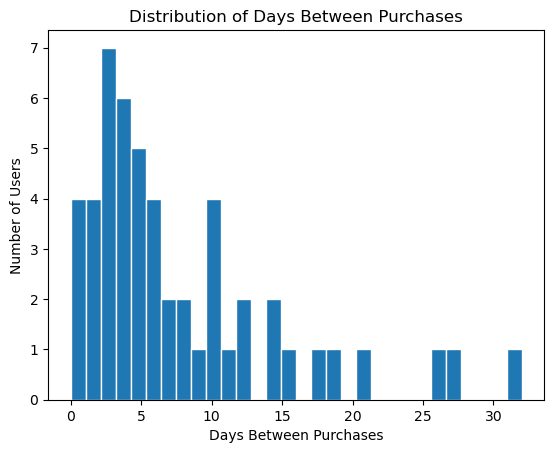

In [85]:
#Plot the distribution 

plt.hist(days_between_purchases_df['norm_days_between_purchases'], bins=30, edgecolor='white')
plt.xlabel('Days Between Purchases')
plt.ylabel('Number of Users')
plt.title('Distribution of Days Between Purchases')
plt.show()


According to the descriptitive stats and the distribution above : 


**Active Recurrent:** ost users make their next purchase within the first 7 days (as indicated by the median of 5 days and a concentrated peak in the histogram)

**Active Empty:** Past day 7, the frequency gradually drops off, but there’s still a noticeable cluster of users between 8–14 days.

**Sleeping:** From around day 15 onward, user activity becomes less frequent, suggesting a “sleeping” phase, which I capped at day 30 because the data still shows some activity up to that point. 

**Inactive:** Beyond 30 days, users essentially disappear from the purchase behavior curve, so that was defined as the cutoff for “inactive.”

## Data Processing: last_purchase_date column

**Purpose**
To classify users by engagement status, we need their most recent purchase date.
This column allows us to measure inactivity periods for status classification.

**Process**
- Sort transactions by user and purchase order.
- Extract the last recorded purchase for each user.
- Rename columns by adding the "last" prefix

In [86]:
# Sort payments df by descending order 
last_purchase_df = payments_copy3_df.sort_values(by=["user_id", "purchase_position"], ascending=True)

#Get the last purchases of each unique user 
last_purchase_info = last_purchase_df.groupby("user_id").last().reset_index()

# Label the last purchase information with  last purchase date and last purchased package 
last_purchase_info = last_purchase_info[["user_id", "payment_date_utc", "package"]].rename(
    columns={"payment_date_utc": "last_purchase_date", "package": "last_purchased_package"}
)



In [87]:
print("Verifying if the retrieved last purchase infos are indeed from the last purchase of the user")

print(f"\nCalculated last purchase date and package: ")
user_id = "b569abca-e7ac-4403-95bf-b10c1a27d286"#pick a random user generated below and check their last purchase date 
last_purchase_info[last_purchase_info["user_id"] == user_id][["last_purchase_date","last_purchased_package"]]

Verifying if the retrieved last purchase infos are indeed from the last purchase of the user
Calculated last purchase date and package: 


,last_purchase_date,last_purchased_package
43,2024-08-16 20:05:10,2


In [92]:
print("User's purchase dates from the original dataset in descending order: \n") 
desc_purchases_df = payments_copy3_df.sort_values(by =["user_id", "payment_date_utc"], ascending = False) 
randomly_print_samples(desc_purchases_df , ["user_id", "payment_date_utc", "package"])


User's purchase dates from the original dataset in descending order: 

Random user 0:
                                  user_id    payment_date_utc  package
44  354f02a1-e51e-4cfa-94e8-559cca811e9d 2024-07-16 19:44:15        4
55  354f02a1-e51e-4cfa-94e8-559cca811e9d 2024-07-10 02:05:19        1

##########

Random user 1:
                                  user_id    payment_date_utc  package
30  34b59bd3-4667-4052-8f73-09fa0f827c89 2024-07-27 17:27:09        8

##########

Random user 2:
                                  user_id    payment_date_utc  package
4   4479b4db-07cf-4bf2-9ce6-671565c9417d 2024-08-18 03:02:27        2
8   4479b4db-07cf-4bf2-9ce6-671565c9417d 2024-08-14 13:10:58        2
49  4479b4db-07cf-4bf2-9ce6-671565c9417d 2024-07-13 06:35:47        1
50  4479b4db-07cf-4bf2-9ce6-671565c9417d 2024-07-13 06:16:00        1

##########

Random user 3:
                                  user_id    payment_date_utc  package
5   a8d9d35a-af81-4c1e-b2a5-fcd9fd44fa51 2024-08-17 14:2

In [93]:


print("Null values: ", last_purchase_info.isna().sum()) 

Null values:  user_id                   0
last_purchase_date        0
last_purchased_package    0
dtype: int64


### Data Processing: Add `last_session_date` column

**What it's column about**
This column will serve to identify the last session activity and classify users' status of those who don't have purchase activity yet

**How it's created**
- Group by each unique user's appointments 
- Get the max value of session date among the user's appointments
- Assign the extracted values to a new column `last_session_date`

In [103]:
last_session_info = (
    appointments_copy_df.groupby("user_id")["session_date"]
    .max()
    .reset_index()
    .rename(columns={"session_date": "last_session_date"})
)


In [107]:
print("Verifying if the retrieved last session infos are indeed from the last session of the user")

print(f"\nCalculated last session date: ")
user_id = "8eb7a838-7889-402f-9058-ae8c4f7fab33" #pick a random user generated below and check their last session date 
last_session_info[last_session_info["user_id"] == user_id][["last_session_date"]]

Verifying if the retrieved last session infos are indeed from the last session of the user

Calculated last session date: 


,last_session_date
166,2024-08-09


In [108]:
print("User's session dates from the original dataset in descending order: \n") 
desc_appointments_df = appointments_copy_df.sort_values(by =["user_id", "session_date"], ascending = False) 
randomly_print_samples(desc_appointments_df , ["user_id", "session_date"])


User's session dates from the original dataset in descending order: 

Random user 0:
                                   user_id        session_date
589  8eb7a838-7889-402f-9058-ae8c4f7fab33 2024-05-07 15:00:00

##########

Random user 1:
                                   user_id        session_date
95   3af05bbf-1273-4f0c-a883-0119030008cd 2024-08-05 19:15:00
624  3af05bbf-1273-4f0c-a883-0119030008cd 2024-04-18 19:00:00
452  3af05bbf-1273-4f0c-a883-0119030008cd 2024-04-04 19:00:00
598  3af05bbf-1273-4f0c-a883-0119030008cd 2024-03-28 18:15:00

##########

Random user 2:
                                   user_id        session_date
3    33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-08-13 18:00:00
343  33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-07-30 18:00:00
575  33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-07-23 18:00:00
270  33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-07-18 18:00:00
611  33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-07-17 18:00:00
450  33507078-c73b-4e42-98db-2d8e9f4e77b9 2024-07-

In [109]:
#Combine the last session and  purchase information
user_status_df = last_purchase_info.merge(last_session_info, on="user_id", how="left")


### Data Processing: Add `has_credits` column 

In [95]:
user_credits_df = pd.read_csv("current_user_credits.csv")

In [110]:
#Check if we have all users from user_status_df in user_credits_df 

user_w_credits = user_credits_df['user_id'].unique()
users_status = user_status_df["user_id"].unique()
print(len(user_w_credits) , len(users_status))
print("Users that it's in users_status but not in user_with_credits: ",  set(users_status) - set(user_w_credits))


53 54
Users that it's in users_status but not in user_with_credits:  {'95448cb2-e98b-497a-96a6-40d9bab369fd'}


Since the user's credit data is missing, we can estimate their status by analyzing their average monthly session frequency. By examining how often they book sessions and the time elapsed since their last session, we can reasonably predict whether they still have remaining credits.

In [111]:

def user_avg_mo_session(df, user_id):
    """
    Calculates a user's average and median session frequency per month.
    """
    df["session_date"] = pd.to_datetime(df["session_date"], errors = "coerce")
    user_sessions = appointments_copy_df[df["user_id"] == user_id].copy()

    
    user_sessions["year_month"] = user_sessions["session_date"].dt.to_period("M")

    # Count sessions per month
    monthly_session_counts = user_sessions.groupby("year_month").size()

    # Calculate the average number of sessions per month
    average_sessions_per_month = monthly_session_counts.mean()
    median_sessions_per_month = monthly_session_counts.median()
    print(f"User {user_id} has an mean of {round(average_sessions_per_month,2)} and median of {round(median_sessions_per_month,2)} sessions per month.")

user_avg_mo_session(appointments_copy_df, user_id)

User b569abca-e7ac-4403-95bf-b10c1a27d286 has an mean of 1.67 and median of 1.0 sessions per month.


User *95448cb2-e98b-497a-96a6-40d9bab369fd* has a mean of 2.25 and a median of 2.0 sessions per month. 
Given their average session frequency, they are unlikely to have exhausted their package of 8 sessions within two months.



In [112]:
user_status_copy_df = user_status_df.copy()

In [113]:
#Merge two dfs first
user_status_copy_df = user_status_copy_df.merge(user_credits_df, on = "user_id", how = "left")

In [114]:

def change_user_credits_status(df, user_id):
    """
     Updates the `has_credits` field for users inferred to still have credits.
    """
    #Filter the specified user and that its credits status is null
    df.loc[(df["user_id"] == user_id) & (df["has_credits"].isna()), 
    "has_credits"
] = "Available"
    
    #Verify
    print(df[df["user_id"] == user_id])
    return df 


#Update the user's credits status 
change_user_credits_status(user_status_copy_df, user_id)

                                 user_id  last_purchase_date  \
43  b569abca-e7ac-4403-95bf-b10c1a27d286 2024-08-16 20:05:10   

    last_purchased_package last_session_date has_credits  
43                       2        2024-08-09   Available  


,user_id,last_purchase_date,last_purchased_package,last_session_date,has_credits
0,02af1545-1f39-46b2-9687-337dd320bd27,2024-07-08 17:28:23,8,2024-08-13 17:30:00,Available
1,02e9d227-1f3f-47ed-a181-9f08e273e47e,2024-08-16 11:32:08,1,2024-08-19 18:00:00,Not Available
2,06aca2cd-efd3-4b99-bd35-9694f922d84c,2024-07-04 17:41:07,1,2024-07-16 13:00:00,Not Available
3,0b71b538-09b6-424e-899d-0b206535d044,2024-07-10 11:46:40,8,2024-08-13 13:30:00,Available
4,0bfdb523-4546-4028-9796-e96ab3becf5f,2024-07-29 20:10:37,8,2024-08-19 16:00:00,Available
5,17763cfe-2a30-47b0-9108-b7784bcd2232,2024-08-05 21:28:26,4,2024-08-13 20:00:00,Available
6,1e171732-9d34-4c78-a087-a75795a6c484,2024-07-29 13:04:20,8,2024-08-14 18:00:00,Available
7,203c3319-a3b4-43f1-9ad1-04f6c861b7a5,2024-07-26 12:33:49,8,2024-07-25 18:00:00,Available
8,21697d81-c5c1-40ca-bdaf-65e676b9e131,2024-07-04 20:54:03,8,2024-08-17 14:00:00,Available
9,2f2dbdf7-7537-4645-a69a-e5e00fcce5b1,2024-06-12 12:33:27,8,2024-08-13 22:00:00,Available


### Data processing: Classifying user status

Now that we have the necessary information `has_credits` and `last_purchase_date` we can assign the user status

In [118]:
user_status_copy2_df = user_status_copy_df.copy()

In [119]:

final_date = pd.to_datetime('2024-08-31 23:59:59')

# Calculate days since last purchase
user_status_copy2_df['days_since_last_purchase'] = (final_date - user_status_copy2_df['last_purchase_date']).dt.days


In [120]:
not_available = user_status_copy2_df[user_status_copy2_df['has_credits'] == "Not Available"]
not_available[["last_purchase_date", "days_since_last_purchase"]]

,last_purchase_date,days_since_last_purchase
1,2024-08-16 11:32:08,15
2,2024-07-04 17:41:07,58
35,2024-07-03 21:23:24,59
37,2024-07-18 23:03:33,44
48,2024-07-25 11:53:21,37
51,2024-05-27 18:14:59,96


In [121]:
user_status_copy3_df = user_status_copy2_df.copy()

In [122]:
def classify_user(row):
    if row['has_credits'] == "Available":
        return "Active Recurrent"
    
    else:
        if row['days_since_last_purchase'] <= 7:
            return "Active Recurrent"
        elif 8 <= row['days_since_last_purchase'] <= 14:
            return "Active Empty"
        elif 15 <= row['days_since_last_purchase'] <= 30:
            return "Sleeping"
        elif row['days_since_last_purchase'] > 30:
            return "Inactive"
        else:
            return "Undefined"

# Apply classification
user_status_copy3_df['user_status'] = user_status_copy3_df.apply(classify_user, axis=1)

# View status distribution
print(user_status_copy3_df['user_status'].value_counts())


Active Recurrent    47
Inactive             6
Sleeping             1
Name: user_status, dtype: int64


In [123]:
#Verifying 
print("Active Recurrent Users: \n")
active_rec_users= user_status_copy3_df[user_status_copy3_df["user_status"] == "Active Recurrent"]
active_rec_no_credits =  active_rec_users[active_rec_users["has_credits"] == "Not Available"]
w_credits =  user_status_copy3_df[user_status_copy3_df["has_credits"] == "Available"]

print("\nActive Reccurent users without credits should not have days_since_last_purchase beyond 7 days: ", active_rec_no_credits[active_rec_no_credits["days_since_last_purchase"] > 7])
print("\nAll users with credits are active recurrent:  ", w_credits["user_status"].unique())

Active Recurrent Users: 


Active Reccurent users without credits should not have days_since_last_purchase beyond 7 days:  Empty DataFrame
Columns: [user_id, last_purchase_date, last_purchased_package, last_session_date, has_credits, days_since_last_purchase, user_status]
Index: []

All users with credits are active recurrent:   ['Active Recurrent']


In [124]:
#Verifying 
# Verifying Active Empty Users
empty_users = user_status_copy3_df[user_status_copy3_df["user_status"] == "Active Empty"]

print("Active Empty Users: \n")
print("Active Empty users should NOT have users where days_since_last_purchase is between 8-14: ")
print(empty_users[~(empty_users["days_since_last_purchase"] >= 8) & 
                             (empty_users["days_since_last_purchase"] <= 14)])

# Verifying Sleeping Users
sleeping_users= user_status_copy3_df[user_status_copy3_df["user_status"] == "Sleep"]

print("\nSleeping Users: \n")
print("Sleeping users should NOT have users where days_since_last_purchase is between 15-30: ")
print(sleeping_users[~(sleeping_users["days_since_last_purchase"] >= 15) & 
                             (sleeping_users["days_since_last_purchase"] <= 30)])

# Verifying Inactive Users
inactive_users= user_status_copy3_df[user_status_copy3_df["user_status"] == "Inactive"]

print("\nInactive Users: \n")
print("Inactive users should NOT have users where days_since_last_purchase is beyond 30: ")
print(inactive_users[~inactive_users["days_since_last_purchase"] > 30])


Active Empty Users: 

Active Empty users should NOT have users where days_since_last_purchase is between 8-14: 
Empty DataFrame
Columns: [user_id, last_purchase_date, last_purchased_package, last_session_date, has_credits, days_since_last_purchase, user_status]
Index: []

Sleeping Users: 

Sleeping users should NOT have users where days_since_last_purchase is between 15-30: 
Empty DataFrame
Columns: [user_id, last_purchase_date, last_purchased_package, last_session_date, has_credits, days_since_last_purchase, user_status]
Index: []

Inactive Users: 

Inactive users should NOT have users where days_since_last_purchase is beyond 30: 
Empty DataFrame
Columns: [user_id, last_purchase_date, last_purchased_package, last_session_date, has_credits, days_since_last_purchase, user_status]
Index: []


In [126]:
user_status_copy3_df

,user_id,last_purchase_date,last_purchased_package,last_session_date,has_credits,days_since_last_purchase,user_status
0,02af1545-1f39-46b2-9687-337dd320bd27,2024-07-08 17:28:23,8,2024-08-13 17:30:00,Available,54,Active Recurrent
1,02e9d227-1f3f-47ed-a181-9f08e273e47e,2024-08-16 11:32:08,1,2024-08-19 18:00:00,Not Available,15,Sleeping
2,06aca2cd-efd3-4b99-bd35-9694f922d84c,2024-07-04 17:41:07,1,2024-07-16 13:00:00,Not Available,58,Inactive
3,0b71b538-09b6-424e-899d-0b206535d044,2024-07-10 11:46:40,8,2024-08-13 13:30:00,Available,52,Active Recurrent
4,0bfdb523-4546-4028-9796-e96ab3becf5f,2024-07-29 20:10:37,8,2024-08-19 16:00:00,Available,33,Active Recurrent
5,17763cfe-2a30-47b0-9108-b7784bcd2232,2024-08-05 21:28:26,4,2024-08-13 20:00:00,Available,26,Active Recurrent
6,1e171732-9d34-4c78-a087-a75795a6c484,2024-07-29 13:04:20,8,2024-08-14 18:00:00,Available,33,Active Recurrent
7,203c3319-a3b4-43f1-9ad1-04f6c861b7a5,2024-07-26 12:33:49,8,2024-07-25 18:00:00,Available,36,Active Recurrent
8,21697d81-c5c1-40ca-bdaf-65e676b9e131,2024-07-04 20:54:03,8,2024-08-17 14:00:00,Available,58,Active Recurrent
9,2f2dbdf7-7537-4645-a69a-e5e00fcce5b1,2024-06-12 12:33:27,8,2024-08-13 22:00:00,Available,80,Active Recurrent


In [125]:
#Export final df 

user_status_copy3_df.to_csv("final_user_status.csv", index = False)